In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm

In [2]:
path_train = r"../train/"

In [3]:
TEST = True

test_wagnums = range(1, 1000)

test_start = pd.to_datetime('2023-01-01')
test_end = pd.to_datetime('2023-03-01')

dislok = pd.read_parquet(path_train + '/dislok_wagons.parquet').convert_dtypes()
dislok['plan_date'] = pd.to_datetime(dislok['plan_date'])

if TEST:
    dislok = dislok[(dislok['plan_date'] >= test_start) & (dislok['plan_date'] <= test_end)]
    dislok = dislok[dislok['wagnum'].isin(test_wagnums)]

freight_data = pd.read_parquet(path_train + '/freight_info.parquet').convert_dtypes()

dislok.fillna(pd.NA, inplace=True)

In [4]:
dislok.shape

(59853, 16)

In [5]:
absent_freights = set(dislok.fr_id.unique()) - set(freight_data.fr_id.unique())
print(f"Absent freights: {len(absent_freights)}")

for fr_id in absent_freights:
    values = {col: 0 for col in freight_data.columns}
    values['fr_id'] = fr_id
    freight_data = pd.concat([freight_data, pd.DataFrame([values])], ignore_index=True)

Absent freights: 3


In [6]:
absent_freights = set(dislok.fr_id.unique()) - set(freight_data.fr_id.unique())
assert len(absent_freights) == 0

In [7]:
dislok = dislok.merge(freight_data, on='fr_id')

In [8]:
del freight_data

In [10]:
dislok.shape

(59853, 24)

In [11]:
dislok.sample(5)

,plan_date,wagnum,date_kap,date_dep,kod_vrab,date_pl_rem,id_road_disl,st_id_dest,id_road_dest,st_id_send,...,last_fr_id,distance,fr_class,skoroport,naval,nasip,naliv,openvagons,soprovod,smerz
58995,2023-01-05,253,NaT,2019-12-06,1,2022-12-06,31,7944,32,12648,...,418,-1,2,0,0,0,0,0,0,0
26764,2023-03-01,209,NaT,2019-11-06,1,2022-11-06,44,11412,42,12382,...,1671,-1,1,0,0,0,0,0,0,0
58417,2023-01-09,864,NaT,2020-08-31,0,2022-08-31,37,7895,31,6265,...,4987,-1,1,0,0,0,0,0,0,0
3376,2023-01-12,321,NaT,2019-07-18,1,2022-07-18,25,22,25,5272,...,365,-1,1,0,0,0,0,0,0,0
26689,2023-03-01,85,2012-05-29,2020-11-16,0,2023-11-16,38,22,38,10374,...,1671,86,1,0,0,0,0,0,0,0


In [12]:
train_df = pd.read_csv(path_train +'/target/y_train.csv').convert_dtypes()
train_df['month'] = pd.to_datetime(train_df['month'])

if TEST:
    train_df = train_df[(train_df['month'] >= test_start) & (train_df['month'] <= test_end)]
    train_df = train_df[train_df['wagnum'].isin(test_wagnums)]

train_df.sample(5)

,wagnum,month,target_month,target_day
233951,783,2023-02-01,0,0
26594,381,2023-01-01,0,0
28093,913,2023-01-01,0,0
229673,331,2023-02-01,0,0
230001,495,2023-02-01,0,0


In [13]:
test_set = pd.read_csv(path_train +'/target/y_predict.csv').convert_dtypes()
wagnums_test = test_set.wagnum.unique()

print(f"Test set size: {len(test_set)}")

test_df = pd.DataFrame({'wagnum': wagnums_test, 'month': [pd.to_datetime('2023-03-01')] * len(wagnums_test)})

if TEST:
    test_df = test_df[test_df['wagnum'].isin(test_wagnums)]

print(len(test_df), train_df.wagnum.nunique())
test_df.sample(5)

Test set size: 33707
996 999


,wagnum,month
28609,179,2023-03-01
26311,482,2023-03-01
28159,745,2023-03-01
25752,362,2023-03-01
26324,424,2023-03-01


In [14]:
all_df = pd.concat([train_df, test_df], ignore_index=True)
all_df.isna().sum()

wagnum            0
month             0
target_month    996
target_day      996
dtype: int64

In [42]:
train_df.target_month.mean()

0.04824101298739676

In [15]:
import gc
gc.collect()

0

### Дислокация вагонов - сбор данных

In [16]:
dislok.columns

Index(['plan_date', 'wagnum', 'date_kap', 'date_dep', 'kod_vrab',
       'date_pl_rem', 'id_road_disl', 'st_id_dest', 'id_road_dest',
       'st_id_send', 'id_road_send', 'ost_prob', 'isload', 'fr_id',
       'last_fr_id', 'distance', 'fr_class', 'skoroport', 'naval', 'nasip',
       'naliv', 'openvagons', 'soprovod', 'smerz'],
      dtype='object')

In [17]:
dislok['days_to_pl_rem'] = (dislok['date_pl_rem'] - dislok['plan_date']).dt.days
dislok['another_road'] = dislok['id_road_dest'] != dislok['id_road_send']
dislok['last_rem_date'] = dislok[['date_kap', 'date_dep']].max(axis=1)
dislok['days_from_last_rem'] = (dislok['plan_date'] - dislok['last_rem_date']).dt.days
dislok = dislok.convert_dtypes()

In [18]:
dislok.sort_values(by='plan_date', inplace=True)

In [19]:
to_fill = ['ost_prob']

median_values = dislok[to_fill].median()
print(median_values)

dislok[to_fill] = dislok.groupby('wagnum')[to_fill].transform(lambda x: x.fillna(method='ffill'))
# dislok[to_fill] = dislok.groupby('wagnum')[to_fill].transform(lambda x: x.fillna(method='bfill'))
dislok[to_fill] = dislok.groupby('wagnum')[to_fill].transform(lambda x: x.fillna(median_values))

ost_prob    115197.0
dtype: float64


In [20]:
dislok.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59853 entries, 0 to 59852
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   plan_date           59853 non-null  datetime64[ns]
 1   wagnum              59853 non-null  Int64         
 2   date_kap            17553 non-null  datetime64[ns]
 3   date_dep            59853 non-null  datetime64[ns]
 4   kod_vrab            59853 non-null  Int64         
 5   date_pl_rem         59853 non-null  datetime64[ns]
 6   id_road_disl        59853 non-null  Int64         
 7   st_id_dest          59853 non-null  Int64         
 8   id_road_dest        59853 non-null  Int64         
 9   st_id_send          59853 non-null  Int64         
 10  id_road_send        59853 non-null  Int64         
 11  ost_prob            59853 non-null  Int64         
 12  isload              59853 non-null  Int64         
 13  fr_id               59853 non-null  Int64         


In [21]:
from collections import Counter

distances = dict()
counter = Counter()

data = dislok[['st_id_send', 'st_id_dest', 'distance']]
data = data[data.distance != -1]

# Compute average distance between each pair of stations
data = data.to_numpy()

for st_id_send, st_id_dest, distance in tqdm(data):
    counter[(st_id_send, st_id_dest)] += 1
    distances[(st_id_send, st_id_dest)] = distances.get((st_id_send, st_id_dest), 0) + distance

for key in distances.keys():
    distances[key] /= counter[key]

  0%|          | 0/16498 [00:00<?, ?it/s]

In [22]:
data = data = dislok[['st_id_send', 'st_id_dest', 'distance']].to_numpy()
found = 0
for i in tqdm(range(len(data))):
    st_id_send, st_id_dest, distance = data[i]
    if distance == -1 and (st_id_send, st_id_dest) in distances:
        found += 1

print(f"Found: {found}")

  0%|          | 0/59853 [00:00<?, ?it/s]

Found: 36462


In [23]:
avg_distances = np.zeros(len(data))
for i in tqdm(range(len(data))):
    st_id_send, st_id_dest, distance = data[i]
    avg_distances[i] = distances.get((st_id_send, st_id_dest), np.nan)


dislok['avg_distance'] = avg_distances
dislok.avg_distance.fillna(dislok.avg_distance.mean(), inplace=True)

  0%|          | 0/59853 [00:00<?, ?it/s]

<Axes: ylabel='Frequency'>

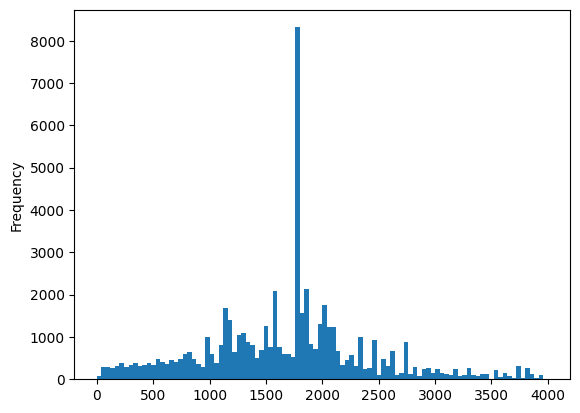

In [24]:
dislok['avg_distance'].plot.hist(bins=100, range=(0, 4000))

In [25]:
wagnum_subtables = {wagnum: table for wagnum, table in tqdm(dislok.groupby('wagnum'))}

  0%|          | 0/999 [00:00<?, ?it/s]

In [28]:
from itertools import product

intervals = [pd.DateOffset(days=5), pd.DateOffset(days=10), pd.DateOffset(days=30), pd.DateOffset(days=60)]
functions = {"isload": ['mean'], "ost_prob": ['min', 'max'], "another_road": ['max'],
              "avg_distance": ['max', 'min']}

fr_classes = ['skoroport', 'naval', 'nasip', 'naliv', 'openvagons', 'soprovod', 'smerz']
for fr_class in fr_classes:
    functions[fr_class] = ['mean']

take_last_cols = ['date_kap', 'date_dep', 'kod_vrab', 'date_pl_rem', 'days_to_pl_rem', 'last_rem_date', 'days_from_last_rem', 'ost_prob']
rolling_cols = set()


for wagnum, table in tqdm(wagnum_subtables.items()):
    for interval in intervals:
        for col, func_list in functions.items():
            for func in func_list:
                table[f"{interval.days}d_{col}_{func}"] = getattr(table[col].rolling(interval.days), func)(engine='numba')
                rolling_cols.add(f"{interval.days}d_{col}_{func}")

for wagnum, table in tqdm(wagnum_subtables.items()):
    table['5d_ost_prob_sum'] = table['5d_ost_prob_max'] - table['5d_ost_prob_min']
    table['10d_ost_prob_sum'] = table['10d_ost_prob_max'] - table['10d_ost_prob_min']
    table['30d_ost_prob_sum'] = table['30d_ost_prob_max'] - table['30d_ost_prob_min']
    table['60d_ost_prob_sum'] = table['60d_ost_prob_max'] - table['60d_ost_prob_min']

    table['5d_prob_mean'] = table['5d_ost_prob_sum'] / 5
    table['10d_prob_mean'] = table['10d_ost_prob_sum'] / 10
    table['30d_prob_mean'] = table['30d_ost_prob_sum'] / 30
    table['60d_prob_mean'] = table['60d_ost_prob_sum'] / 60

    

for newcol in ['5d_prob_mean', '10d_prob_mean', '30d_prob_mean', '60d_prob_mean', '5d_ost_prob_sum', '10d_ost_prob_sum', '30d_ost_prob_sum', '60d_ost_prob_sum']:
    rolling_cols.add(newcol)

columns_to_add = list(rolling_cols) + take_last_cols

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

In [30]:
wagnum_subtables[1][['plan_date', '30d_ost_prob_min', '30d_ost_prob_max', '30d_prob_mean', '30d_ost_prob_sum']].sample(10)

,plan_date,30d_ost_prob_min,30d_ost_prob_max,30d_prob_mean,30d_ost_prob_sum
15921,2023-02-06,93045.0,93069.0,0.800000,24.0
15918,2023-02-03,93045.0,93069.0,0.800000,24.0
2883,2023-01-26,NaN,NaN,NaN,NaN
15941,2023-02-26,83324.0,93045.0,324.033333,9721.0
2863,2023-01-06,NaN,NaN,NaN,NaN
15939,2023-02-24,83324.0,93045.0,324.033333,9721.0
2858,2023-01-01,NaN,NaN,NaN,NaN
15919,2023-02-04,93045.0,93069.0,0.800000,24.0
15937,2023-02-22,83324.0,93045.0,324.033333,9721.0
2865,2023-01-08,NaN,NaN,NaN,NaN


In [31]:
columns_to_add

['60d_isload_mean',
 '10d_another_road_max',
 '30d_soprovod_mean',
 '30d_naval_mean',
 '10d_prob_mean',
 '30d_avg_distance_min',
 '30d_another_road_max',
 '30d_skoroport_mean',
 '10d_openvagons_mean',
 '60d_avg_distance_max',
 '10d_soprovod_mean',
 '60d_prob_mean',
 '5d_ost_prob_min',
 '60d_ost_prob_min',
 '10d_naliv_mean',
 '30d_avg_distance_max',
 '10d_skoroport_mean',
 '30d_ost_prob_max',
 '30d_smerz_mean',
 '60d_avg_distance_min',
 '5d_nasip_mean',
 '30d_nasip_mean',
 '60d_ost_prob_sum',
 '30d_ost_prob_sum',
 '5d_avg_distance_max',
 '60d_nasip_mean',
 '10d_naval_mean',
 '60d_skoroport_mean',
 '10d_ost_prob_max',
 '5d_naval_mean',
 '5d_avg_distance_min',
 '5d_another_road_max',
 '30d_openvagons_mean',
 '30d_isload_mean',
 '30d_prob_mean',
 '10d_avg_distance_min',
 '5d_openvagons_mean',
 '5d_prob_mean',
 '60d_naval_mean',
 '60d_another_road_max',
 '60d_soprovod_mean',
 '10d_ost_prob_min',
 '5d_smerz_mean',
 '5d_ost_prob_sum',
 '60d_ost_prob_max',
 '30d_ost_prob_min',
 '30d_naliv_mean

In [32]:
all_df.sort_values(by=['month', 'wagnum'], inplace=True)

data = pd.concat([wagnum_subtables[wagnum] for wagnum in tqdm(wagnum_subtables.keys())])
data = data[columns_to_add + ['wagnum', 'plan_date']]
data.rename({'plan_date': 'month'}, axis=1, inplace=True)
all_df_new = all_df.merge(data, on=['month', 'wagnum'], how='left')
    

all_df_new.sample(5)

  0%|          | 0/999 [00:00<?, ?it/s]

,wagnum,month,target_month,target_day,60d_isload_mean,10d_another_road_max,30d_soprovod_mean,30d_naval_mean,10d_prob_mean,30d_avg_distance_min,...,60d_openvagons_mean,5d_isload_mean,date_kap,date_dep,kod_vrab,date_pl_rem,days_to_pl_rem,last_rem_date,days_from_last_rem,ost_prob
404,405,2023-01-01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaT,2020-05-13,1,2023-05-13,132,2020-05-13,963,66652
406,407,2023-01-01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaT,2019-10-30,1,2022-10-30,-63,2019-10-30,1159,151569
2831,840,2023-03-01,<NA>,<NA>,0.9,1.0,0.0,0.0,0.0,1565.685279,...,0.0,0.0,NaT,2021-10-25,0,2023-10-25,238,2021-10-25,492,115197
1133,138,2023-02-01,0,0,NaN,1.0,0.0,0.5,134.5,153.500000,...,NaN,0.0,NaT,2019-12-27,1,2022-12-27,-36,2019-12-27,1132,151538
1984,989,2023-02-01,0,0,NaN,1.0,0.0,0.0,0.0,255.000000,...,NaN,1.0,NaT,2020-07-06,0,2023-07-06,155,2020-07-06,940,36000


In [33]:
all_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2991 entries, 0 to 2990
Data columns (total 72 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   wagnum                2991 non-null   Int64         
 1   month                 2991 non-null   datetime64[ns]
 2   target_month          1995 non-null   Int64         
 3   target_day            1995 non-null   Int64         
 4   60d_isload_mean       996 non-null    float64       
 5   10d_another_road_max  1992 non-null   float64       
 6   30d_soprovod_mean     1992 non-null   float64       
 7   30d_naval_mean        1992 non-null   float64       
 8   10d_prob_mean         1992 non-null   float64       
 9   30d_avg_distance_min  1992 non-null   float64       
 10  30d_another_road_max  1992 non-null   float64       
 11  30d_skoroport_mean    1992 non-null   float64       
 12  10d_openvagons_mean   1992 non-null   float64       
 13  60d_avg_distance_m

In [34]:
all_df_new.month.unique()

<DatetimeArray>
['2023-01-01 00:00:00', '2023-02-01 00:00:00', '2023-03-01 00:00:00']
Length: 3, dtype: datetime64[ns]

### Тип владения вагоном - сбор данных

In [41]:
# For rows in wag_prob with repdate == 2023-02-28, add the same row with repdate == 2023-03-01

wag_prob = pd.read_parquet(path_train + '/wagons_probeg_ownersip.parquet').convert_dtypes()
print(wag_prob.shape)

rows = wag_prob[wag_prob['repdate'] == pd.to_datetime('2023-02-28')].copy()
rows['repdate'] = pd.to_datetime('2023-03-01')
wag_prob = pd.concat([wag_prob, rows], ignore_index=True)
print(wag_prob.shape)

wag_prob.sample(10)

(7193667, 8)
(7227374, 8)


,repdate,wagnum,ost_prob,manage_type,rod_id,reestr_state,ownership_type,month
476757,2022-12-26,14249,142555,0,1,1,0,12
1771899,2022-09-09,5892,134553,0,0,1,0,9
5986803,2022-08-12,6187,16147,0,0,1,0,8
7175313,2023-02-15,25600,146934,0,1,1,0,2
2302740,2022-09-24,27412,154088,0,1,1,0,9
6619151,2023-02-03,33824,337184,0,1,1,0,2
5142040,2022-11-13,5130,15351,0,0,1,0,11
2971914,2022-09-18,13273,54611,0,1,1,0,9
5448997,2023-01-03,28931,139541,0,1,1,0,1
3282318,2022-10-12,7991,135599,0,0,1,0,10


In [42]:
wag_prob_months = wag_prob[wag_prob.repdate.dt.day == 1].copy()
print(wag_prob_months.shape)

wag_prob_months.drop(['ost_prob', 'month'], axis=1, inplace=True)
wag_prob_months.rename({'repdate': 'month'}, axis=1, inplace=True)

all_df_new_ = all_df_new.merge(wag_prob_months, on=['month', 'wagnum'], how='left')
all_df_new_.sample(5)

(271267, 8)


,wagnum,month,target_month,target_day,60d_isload_mean,10d_another_road_max,30d_soprovod_mean,30d_naval_mean,10d_prob_mean,30d_avg_distance_min,...,kod_vrab,date_pl_rem,days_to_pl_rem,last_rem_date,days_from_last_rem,ost_prob,manage_type,rod_id,reestr_state,ownership_type
33,34,2023-01-01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2024-07-01,547,2021-11-10,417,115945,0,0,1,0
2132,141,2023-03-01,<NA>,<NA>,0.3,0.0,0.0,0.0,0.0,1565.685279,...,1,2022-11-27,-94,2019-11-27,1190,141525,0,0,1,0
2831,840,2023-03-01,<NA>,<NA>,0.9,1.0,0.0,0.0,0.0,1565.685279,...,0,2023-10-25,238,2021-10-25,492,115197,0,0,1,0
340,341,2023-01-01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,1,2022-11-22,-40,2019-11-22,1136,157877,0,0,1,0
712,713,2023-01-01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,2024-04-06,461,2021-04-06,635,85871,0,0,1,0


In [45]:
all_df_new = all_df_new_

### Характеристики вагонов - сбор данных

In [46]:
wag_param = pd.read_parquet(path_train + '/wag_params.parquet').convert_dtypes()
wag_param.columns

Index(['wagnum', 'model', 'rod_id', 'gruz', 'cnsi_gruz_capacity',
       'cnsi_volumek', 'tara', 'date_build', 'srok_sl', 'zavod_build',
       'date_iskl', 'cnsi_probeg_dr', 'cnsi_probeg_kr', 'kuzov', 'telega',
       'tormoz', 'tipvozd', 'tippogl', 'norma_km', 'ownertype'],
      dtype='object')

In [47]:
all_df_new = all_df_new.merge(wag_param, on=['wagnum'], how='left')
all_df_new.sample(5)

,wagnum,month,target_month,target_day,60d_isload_mean,10d_another_road_max,30d_soprovod_mean,30d_naval_mean,10d_prob_mean,30d_avg_distance_min,...,date_iskl,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype
2990,999,2023-03-01,<NA>,<NA>,0.350000,1.0,0.0,0.000000,260.6,251.428571,...,NaT,110,160,2,9,2,7,12,160000,0
460,461,2023-01-01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,110,160,2,9,2,6,11,160000,0
130,131,2023-01-01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,110,160,2,9,2,4,11,160000,0
1448,453,2023-02-01,0,0,NaN,1.0,0.0,0.166667,255.6,371.000000,...,NaT,110,160,2,9,2,4,11,160000,0
2586,595,2023-03-01,<NA>,<NA>,0.516667,1.0,0.0,0.000000,0.0,658.000000,...,NaT,110,160,2,9,2,6,11,160000,0


In [48]:
all_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2991 entries, 0 to 2990
Data columns (total 95 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   wagnum                2991 non-null   Int64         
 1   month                 2991 non-null   datetime64[ns]
 2   target_month          1995 non-null   Int64         
 3   target_day            1995 non-null   Int64         
 4   60d_isload_mean       996 non-null    float64       
 5   10d_another_road_max  1992 non-null   float64       
 6   30d_soprovod_mean     1992 non-null   float64       
 7   30d_naval_mean        1992 non-null   float64       
 8   10d_prob_mean         1992 non-null   float64       
 9   30d_avg_distance_min  1992 non-null   float64       
 10  30d_another_road_max  1992 non-null   float64       
 11  30d_skoroport_mean    1992 non-null   float64       
 12  10d_openvagons_mean   1992 non-null   float64       
 13  60d_avg_distance_m

<Axes: ylabel='Frequency'>

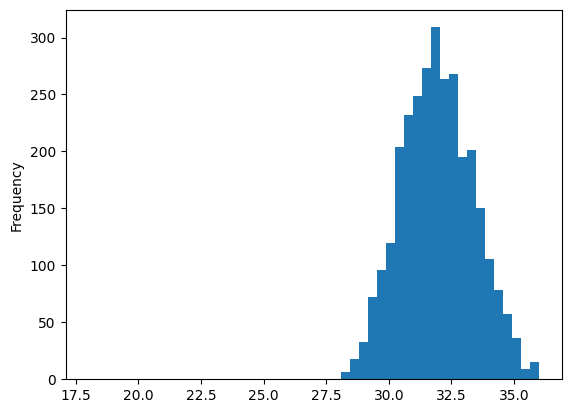

In [49]:
all_df_new['expected_srok_sl_y'] = (all_df_new['srok_sl'] - all_df_new['date_build']).dt.days / 365
all_df_new['expected_srok_sl_y'].plot.hist(bins=50, range=(18, 36))

In [50]:
all_df_new['expected_srok_sl_y_b'] = all_df_new['expected_srok_sl_y'].apply(lambda x: "short" if x <= 27.5 else "long")
all_df_new['expected_srok_sl_y_b'].value_counts()

expected_srok_sl_y_b
long    2991
Name: count, dtype: int64

In [51]:
all_df_new['date_build_b'] = pd.cut(all_df_new['date_build'].dt.year, bins=[0, 2000, 2007, 2017, 2030])
all_df_new['date_build_b'].value_counts()

date_build_b
(2007, 2017]    2322
(0, 2000]        390
(2000, 2007]     279
(2017, 2030]       0
Name: count, dtype: int64

### Просмотр результата и сохранение

In [52]:
all_df_new.shape

(2991, 98)

In [53]:
all_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2991 entries, 0 to 2990
Data columns (total 98 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   wagnum                2991 non-null   Int64         
 1   month                 2991 non-null   datetime64[ns]
 2   target_month          1995 non-null   Int64         
 3   target_day            1995 non-null   Int64         
 4   60d_isload_mean       996 non-null    float64       
 5   10d_another_road_max  1992 non-null   float64       
 6   30d_soprovod_mean     1992 non-null   float64       
 7   30d_naval_mean        1992 non-null   float64       
 8   10d_prob_mean         1992 non-null   float64       
 9   30d_avg_distance_min  1992 non-null   float64       
 10  30d_another_road_max  1992 non-null   float64       
 11  30d_skoroport_mean    1992 non-null   float64       
 12  10d_openvagons_mean   1992 non-null   float64       
 13  60d_avg_distance_m

In [54]:
train_df_new = all_df_new[all_df_new.target_month.notna()]
test_df_new = all_df_new[all_df_new.target_month.isna()]

print(train_df_new.shape, test_df_new.shape)

(1995, 98) (996, 98)


In [ ]:
train_df_new.to_csv(path_train + '/data/train.csv', index=False)
test_df_new.to_csv(path_train + '/data/test.csv', index=False)